### Download celeba from zip file

In [2]:
import zipfile
import os

# Specify the path to your ZIP file
zip_file_path = 'data/celeba_256/images/archive.zip'

# Determine the extraction directory (same as the ZIP file's location)
extraction_directory = os.path.dirname(zip_file_path)

# Open the ZIP file in read mode
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extraction_directory)

print("Extraction complete.")


Extraction complete.


### Tensorboard Viewing

In [3]:
!cd checkpoints/
!tensorboard --logdir ./

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### Check out Pre-trained VAE

In [4]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import numpy as np
from os.path import join as oj
import matplotlib.pyplot as plt
from models import vae
plt.style.use('dark_background')
def to_im(x):
    return x.cpu().detach().numpy().reshape((28, 28))

In [5]:
net = vae.VAE()
net.load_state_dict(torch.load('models/weights/vae_epoch_25.pth'))

<All keys matched successfully>

In [8]:
im0 = datasets.MNIST(root='data', train=True, download=True).data[0].float()
im1 = datasets.MNIST(root='data', train=True).data[1].float()
im2 = datasets.MNIST(root='data', train=True).data[2].float()

100%|██████████| 9912422/9912422 [00:00<00:00, 104470510.66it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42488843.85it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34199331.41it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8082532.36it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



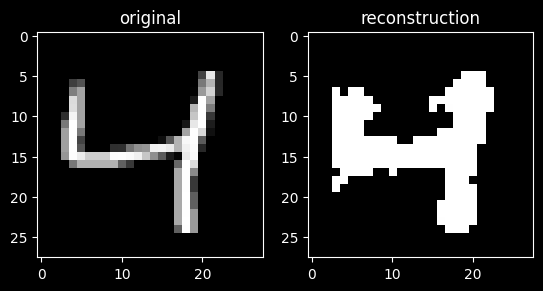

In [17]:
plt.subplot(1, 2, 1)
plt.imshow(im2, cmap='gray')
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(im2_reconstructed, cmap='gray')
plt.title('reconstruction')
plt.show()

In [12]:
(mu0, logvar0) = net.encode(im0.reshape(-1, 784))
(mu1, logvar1) = net.encode(im1.reshape(-1, 784))
(mu2, logvar2) = net.encode(im2.reshape(-1, 784))

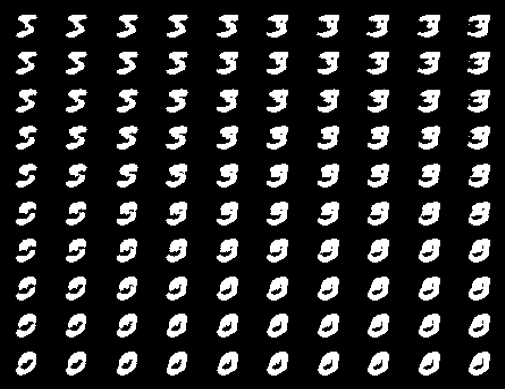

In [13]:
R, C = 10, 10
i = 0
for r, w1 in enumerate(np.linspace(0, 1, 10)):
    for c, w2 in enumerate(np.linspace(0, 1, 10)):
        plt.subplot(R, C, i + 1)
        plt.imshow(to_im(net.decode(mu0 + w1 * mu1 + w2 * mu2)), cmap='gray')
        plt.axis('off')
        i += 1
plt.show()

### Viewing Tensorboard Results

##### Iterate over csv files and synthesize into one dataset

In [110]:
import os
import csv
import re

def synthesize_data(directory_path):
    output_file = 'results/inference_results_ni1000.csv'
    
    with open(output_file, mode='w', newline='') as file_out:
        writer = csv.writer(file_out)
        # Update the header row to include teacher_timesteps and student_timesteps instead of experiment
        writer.writerow(['step', 'fid', 'skip_factor', 'dataset', 'teacher_timesteps', 'student_timesteps'])
        
        for filename in os.listdir(directory_path):
            if filename.endswith('.csv'):
                # Extract skip_factor and dataset from the filename
                skip_factor_match = re.search(r'_sf(\d+)_', filename)
                dataset_match = re.search(r'run-(.+?)_exp', filename)
                # Extract teacher_timesteps and student_timesteps
                timesteps_match = re.search(r'_exp_(\d+)_(\d+)_', filename)
                
                skip_factor = skip_factor_match.group(1) if skip_factor_match else 'nan'
                dataset = dataset_match.group(1) if dataset_match else 'Unknown'
                
                # Extract or default to 'nan' if not present
                teacher_timesteps, student_timesteps = timesteps_match.groups() if timesteps_match else ('nan', 'nan')
                
                file_path = os.path.join(directory_path, filename)
                
                with open(file_path, mode='r') as file_in:
                    reader = csv.DictReader(file_in)
                    for row in reader:
                        writer.writerow([row['Step'], row['Value'], skip_factor, dataset, teacher_timesteps, student_timesteps])

directory_path = 'results/raw_results/'
synthesize_data(directory_path)


In [111]:
import pandas as pd
df = pd.read_csv('results/inference_results_ni1000.csv')

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_fid_by_step_and_skip_factor(df, dataset_name, best_run=False):
    # Filter the DataFrame for the specified dataset
    df = df[df['dataset'] == dataset_name]
    
    # Order the DataFrame by 'skip_factor' and then by 'step'
    condition = ((df['step'] == df['student_timesteps']) |
                 ((df['step'] == 1024) & 
                  (np.isnan(df['teacher_timesteps'])) & 
                  (np.isnan(df['student_timesteps']))))

    df = df[condition]
    df = df.sort_values(by=['skip_factor', 'step'])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    skip_factors = df['skip_factor'].dropna().round().astype(int).unique()

    if best_run:
        # Explicitly initialize an empty DataFrame
        min_fid_df = pd.DataFrame()
        
        for skip_factor in skip_factors:
            skip_df = df[(df['skip_factor'].isna()) | (df['skip_factor'] == skip_factor)]
            
            df_filled = skip_df.fillna({'teacher_timesteps': 'missing', 'student_timesteps': 'missing', 'skip_factor': 'missing'})
            
            idx = df_filled.groupby(['teacher_timesteps', 'student_timesteps', 'skip_factor'])['fid'].idxmin()
            
            # Use pd.concat instead of append to add the rows with minimum 'fid' for this skip_factor to min_fid_df
            min_fid_df = pd.concat([min_fid_df, df.loc[idx]])
            print(f'this is min_fid_df')
            display(min_fid_df)

        sorted_min_fid_df = min_fid_df.sort_values(by=['skip_factor', 'step'])
        print('this is sorted_min_fid_df')
        display(sorted_min_fid_df)
        
        for skip_factor in skip_factors:
            # TODO
            # fix here
            filtered_df = sorted_min_fid_df[(sorted_min_fid_df['skip_factor'].isna()) | (sorted_min_fid_df['skip_factor'] == skip_factor)]
            print('this is filtered_df')
            display(filtered_df)
            if not filtered_df.empty:
                plt.plot(np.log2(filtered_df['step']), filtered_df['fid'], marker='o', linestyle='-', label=f'Skip Factor {skip_factor}')


        
    else:
        # Loop through each skip_factor to plot them as separate lines for the non-best_run scenario
        for skip_factor in skip_factors:
            # Filter for the specific skip factor
            skip_df = df[(df['skip_factor'].isna()) | (df['skip_factor'] == skip_factor)]

            # Additional filter: Either 'teacher_timesteps' and 'student_timesteps' both are NaN, or pass through all
            filtered_df = skip_df[
                (skip_df['teacher_timesteps'].isna() & skip_df['student_timesteps'].isna())
                | (skip_df['step'] == skip_df['student_timesteps'])
            ]
            
            # Plot if there's data after filtering
            if not filtered_df.empty:
                plt.plot(np.log2(filtered_df['step']), filtered_df['fid'], marker='o', linestyle='-', label=f'Skip Factor {skip_factor}')
    
    # Setting up the x-axis with linear spacing on a logarithmic scale
    if not df.empty:
        min_step, max_step = np.log2(df['step'].min()), np.log2(df['step'].max())
        plt.xticks(np.arange(min_step, max_step + 1, 1), labels=[str(int(2**x)) for x in np.arange(min_step, max_step + 1, 1)])
    
    # Setting up the rest of the plot
    plt.title(f'FID Score by Step for {dataset_name.upper()} Dataset')
    plt.xlabel('Step (Log2 Scale)')
    plt.ylabel('FID Score')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    
    # Show plot
    plt.show()


In [212]:
plt.style.use('default')

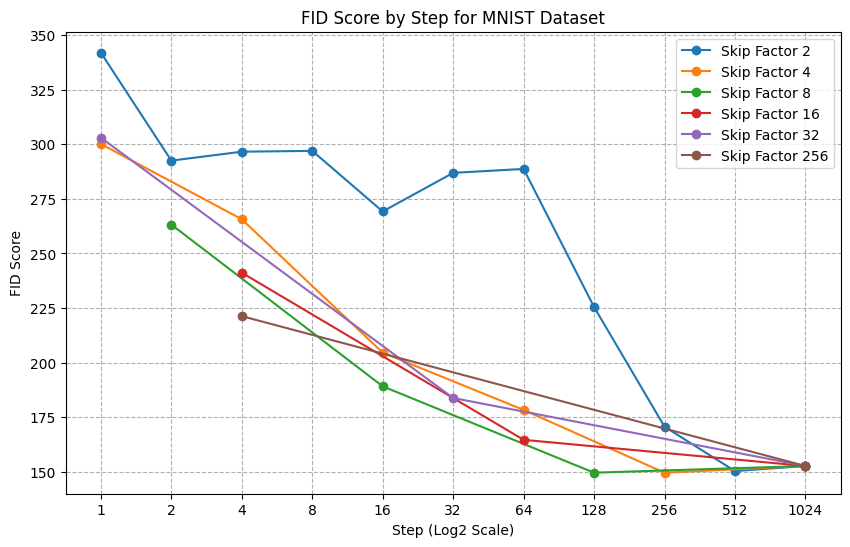

In [213]:
plot_fid_by_step_and_skip_factor(df, 'mnist')

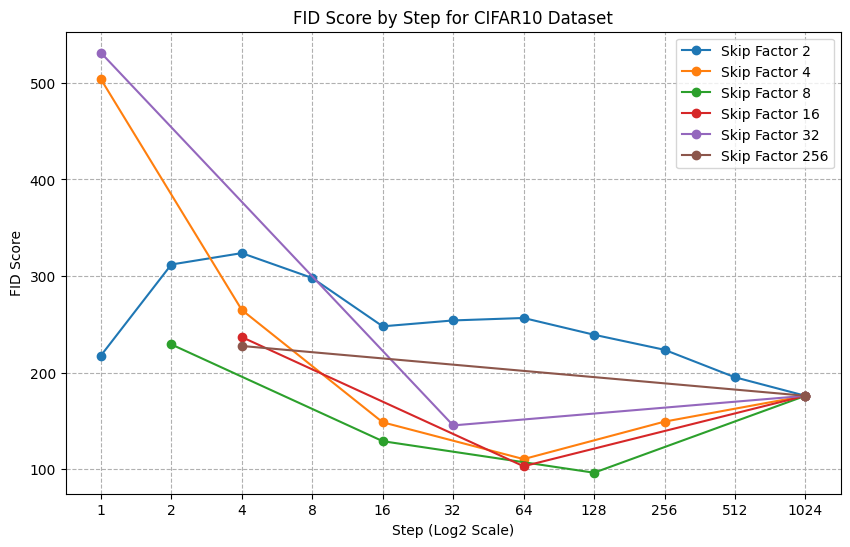

In [214]:
plot_fid_by_step_and_skip_factor(df, 'cifar10')

this is min_fid_df


,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps
113,1,341.871704,2.0,mnist,2.0,1.0
31,2,292.478638,2.0,mnist,4.0,2.0
50,4,296.566650,2.0,mnist,8.0,4.0
154,8,296.941223,2.0,mnist,16.0,8.0
108,16,269.208679,2.0,mnist,32.0,16.0
146,32,286.879944,2.0,mnist,64.0,32.0
91,64,288.672333,2.0,mnist,128.0,64.0
3,128,225.484024,2.0,mnist,256.0,128.0
7,256,170.691299,2.0,mnist,512.0,256.0
43,512,150.378525,2.0,mnist,1024.0,512.0


this is min_fid_df


,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps
113,1,341.871704,2.0,mnist,2.0,1.0
31,2,292.478638,2.0,mnist,4.0,2.0
50,4,296.566650,2.0,mnist,8.0,4.0
154,8,296.941223,2.0,mnist,16.0,8.0
108,16,269.208679,2.0,mnist,32.0,16.0
146,32,286.879944,2.0,mnist,64.0,32.0
91,64,288.672333,2.0,mnist,128.0,64.0
3,128,225.484024,2.0,mnist,256.0,128.0
7,256,170.691299,2.0,mnist,512.0,256.0
43,512,150.378525,2.0,mnist,1024.0,512.0


this is min_fid_df


,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps
113,1,341.871704,2.0,mnist,2.0,1.0
31,2,292.478638,2.0,mnist,4.0,2.0
50,4,296.566650,2.0,mnist,8.0,4.0
154,8,296.941223,2.0,mnist,16.0,8.0
108,16,269.208679,2.0,mnist,32.0,16.0
146,32,286.879944,2.0,mnist,64.0,32.0
91,64,288.672333,2.0,mnist,128.0,64.0
3,128,225.484024,2.0,mnist,256.0,128.0
7,256,170.691299,2.0,mnist,512.0,256.0
43,512,150.378525,2.0,mnist,1024.0,512.0


this is min_fid_df


,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps
113,1,341.871704,2.0,mnist,2.0,1.0
31,2,292.478638,2.0,mnist,4.0,2.0
50,4,296.566650,2.0,mnist,8.0,4.0
154,8,296.941223,2.0,mnist,16.0,8.0
108,16,269.208679,2.0,mnist,32.0,16.0
146,32,286.879944,2.0,mnist,64.0,32.0
91,64,288.672333,2.0,mnist,128.0,64.0
3,128,225.484024,2.0,mnist,256.0,128.0
7,256,170.691299,2.0,mnist,512.0,256.0
43,512,150.378525,2.0,mnist,1024.0,512.0


this is min_fid_df


,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps
113,1,341.871704,2.0,mnist,2.0,1.0
31,2,292.478638,2.0,mnist,4.0,2.0
50,4,296.566650,2.0,mnist,8.0,4.0
154,8,296.941223,2.0,mnist,16.0,8.0
108,16,269.208679,2.0,mnist,32.0,16.0
146,32,286.879944,2.0,mnist,64.0,32.0
91,64,288.672333,2.0,mnist,128.0,64.0
3,128,225.484024,2.0,mnist,256.0,128.0
7,256,170.691299,2.0,mnist,512.0,256.0
43,512,150.378525,2.0,mnist,1024.0,512.0


this is min_fid_df


,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps
113,1,341.871704,2.0,mnist,2.0,1.0
31,2,292.478638,2.0,mnist,4.0,2.0
50,4,296.566650,2.0,mnist,8.0,4.0
154,8,296.941223,2.0,mnist,16.0,8.0
108,16,269.208679,2.0,mnist,32.0,16.0
146,32,286.879944,2.0,mnist,64.0,32.0
91,64,288.672333,2.0,mnist,128.0,64.0
3,128,225.484024,2.0,mnist,256.0,128.0
7,256,170.691299,2.0,mnist,512.0,256.0
43,512,150.378525,2.0,mnist,1024.0,512.0


this is sorted_min_fid_df


,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps
113,1,341.871704,2.0,mnist,2.0,1.0
31,2,292.478638,2.0,mnist,4.0,2.0
50,4,296.566650,2.0,mnist,8.0,4.0
154,8,296.941223,2.0,mnist,16.0,8.0
108,16,269.208679,2.0,mnist,32.0,16.0
146,32,286.879944,2.0,mnist,64.0,32.0
91,64,288.672333,2.0,mnist,128.0,64.0
3,128,225.484024,2.0,mnist,256.0,128.0
7,256,170.691299,2.0,mnist,512.0,256.0
43,512,150.378525,2.0,mnist,1024.0,512.0


this is filtered_df


,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps
113,1,341.871704,2.0,mnist,2.0,1.0
31,2,292.478638,2.0,mnist,4.0,2.0
50,4,296.566650,2.0,mnist,8.0,4.0
154,8,296.941223,2.0,mnist,16.0,8.0
108,16,269.208679,2.0,mnist,32.0,16.0
146,32,286.879944,2.0,mnist,64.0,32.0
91,64,288.672333,2.0,mnist,128.0,64.0
3,128,225.484024,2.0,mnist,256.0,128.0
7,256,170.691299,2.0,mnist,512.0,256.0
43,512,150.378525,2.0,mnist,1024.0,512.0


this is filtered_df


,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps
8,1,300.098206,4.0,mnist,4.0,1.0
29,4,265.645508,4.0,mnist,16.0,4.0
62,16,204.589905,4.0,mnist,64.0,16.0
81,64,178.365616,4.0,mnist,256.0,64.0
77,256,149.619247,4.0,mnist,1024.0,256.0


this is filtered_df


,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps
64,2,263.205170,8.0,mnist,16.0,2.0
12,16,189.160202,8.0,mnist,128.0,16.0
47,128,149.621414,8.0,mnist,1024.0,128.0


this is filtered_df


,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps
162,4,241.179596,16.0,mnist,64.0,4.0
35,64,164.682129,16.0,mnist,1024.0,64.0


this is filtered_df


,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps
18,1,302.975555,32.0,mnist,32.0,1.0
123,32,183.824203,32.0,mnist,1024.0,32.0


this is filtered_df


,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps
26,4,221.287094,256.0,mnist,1024.0,4.0


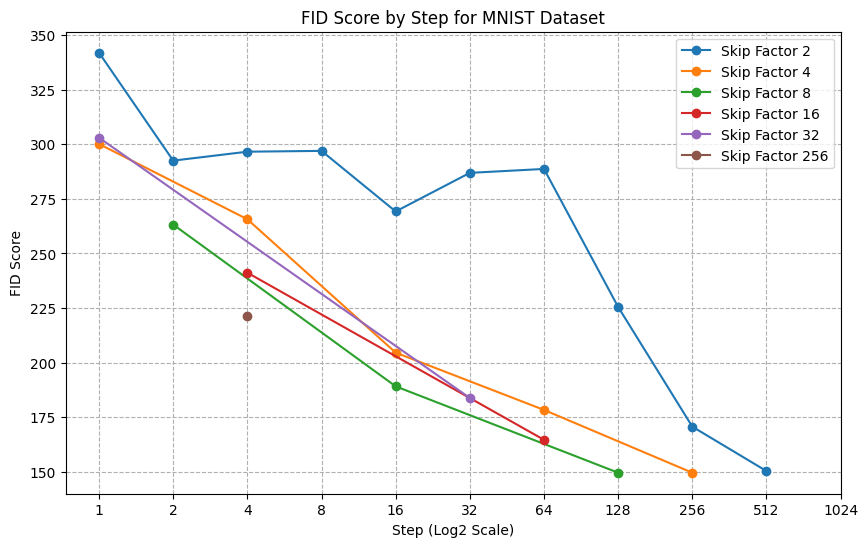

In [210]:
plot_fid_by_step_and_skip_factor(df, 'mnist', best_run=True)